In [13]:
# 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

# 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

# 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 设置pandas
pd.set_option('max_rows', 10)
pd.set_option('max_columns', 50)

In [14]:
# 加载数据
import os
import wget

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


def read_csv(path, seq=' ', remote=False):
    """读取csv,若是远程文件第一次远程读取，下载在本地，以后直接从本地读取"""
    out_path = path.split('/')[-1] + '.csv'        
    if not remote:
        return pd.read_csv(out_path, seq)
    if os.path.exists(out_path):
        os.remove(out_path)
    wget.download(path, out_path)
    return pd.read_csv(out_path, seq)

In [15]:
train_df = read_csv('https://query.data.world/s/gthedhekbujsbrb2xv6xw5upd2cpvn')
test_df = read_csv('https://query.data.world/s/sclhycnxm36nefhxqis7itzs6wz5g5')

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 35.48 MB
Memory usage after optimization is: 9.73 MB
Decreased by 72.6%
Memory usage of dataframe is 11.44 MB
Memory usage after optimization is: 3.05 MB
Decreased by 73.3%


## 数据概览

- ~~SaleID(去掉): 交易ID，唯一标识~~
- ~~name(去掉): 汽车交易名称，已脱敏~~
- regDate: 汽车注册日期，例如20160101
- model: 车型编码，已脱敏 （数据缺失）
- brand: 汽车品牌，已脱敏
- bodyType: 车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7 （数据缺失）
- fuelType: 燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6 （数据缺失）
- gearbox: 变速箱：手动：0，自动：1 （数据缺失）
- power: 发动机功率：范围 [ 0, 600 ]
- kilometer: 汽车已行驶公里，单位万km
- notRepairedDamage: 汽车有尚未修复的损坏：是：0，否：1 （数据缺失）
- regionCode: 地区编码，已脱敏
- ~~seller(去掉): 销售方：个体：0，非个体：1(因为枚举值1只有一条)~~
- ~~offerType(去掉): 报价类型：提供：0，请求：1(因为枚举值只有0,对应的皮尔逊系数也为NULL)~~
- creatDate: 汽车上线时间，即开始售卖时间
- v系列特征: 匿名特征，包含v0-14在内15个匿名特征
- price: 二手车交易价格（预测目标）

In [8]:
print('train_df shape: ', train_df.shape)
print('test_df shape: ', test_df.shape)

train_df shape:  (150000, 31)
test_df shape:  (50000, 30)


### 数据概览

训练集(15w)

- model: 149999
- bodyType: 145494
- fuelType: 141320
- gearbox: 144019
- notRepairedDamage: 0.0, 1.0, -(缺失)

测试集(5w)

- bodyType: 48587
- fuelType: 47107
- gearbox: 48090


In [9]:
train_df.head(5)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.31250,5.234375,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   SaleID             150000 non-null  int32   
 1   name               150000 non-null  int32   
 2   regDate            150000 non-null  int32   
 3   model              149999 non-null  float16 
 4   brand              150000 non-null  int8    
 5   bodyType           145494 non-null  float16 
 6   fuelType           141320 non-null  float16 
 7   gearbox            144019 non-null  float16 
 8   power              150000 non-null  int16   
 9   kilometer          150000 non-null  float16 
 10  notRepairedDamage  150000 non-null  category
 11  regionCode         150000 non-null  int16   
 12  seller             150000 non-null  int8    
 13  offerType          150000 non-null  int8    
 14  creatDate          150000 non-null  int32   
 15  price              150000 non-null

In [4]:
train_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.0,150000.000000,145494.0,141320.0,144019.0,150000.000000,150000.0,150000.000000,150000.000000,150000.0,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,NaN,8.052733,NaN,0.0,0.0,119.316547,NaN,2583.077267,0.000007,0.0,2.016033e+07,5923.327333,NaN,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
std,43301.414527,61103.875095,5.364988e+04,0.0,7.864956,0.0,0.0,0.0,177.168419,0.0,1885.363218,0.002582,0.0,1.067328e+02,7501.998477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,1.991000e+07,0.0,0.000000,0.0,0.0,0.0,0.000000,0.5,0.000000,0.000000,0.0,2.015062e+07,11.000000,30.453125,-4.296875,-4.468750,-7.273438,-4.363281,0.000000,0.000000,0.000000,0.000000,0.000000,-9.171875,-5.558594,-9.640625,-4.152344,-6.546875
25%,37499.750000,11156.000000,1.999091e+07,10.0,1.000000,0.0,0.0,0.0,75.000000,12.5,1018.000000,0.000000,0.0,2.016031e+07,1300.000000,43.125000,-3.191406,-0.970703,-1.462891,-0.921387,0.243652,0.000038,0.062469,0.035339,0.033936,-3.722656,-1.951172,-1.872070,-1.057617,-0.437012
50%,74999.500000,51638.000000,2.003091e+07,30.0,6.000000,1.0,0.0,0.0,110.000000,15.0,2196.000000,0.000000,0.0,2.016032e+07,3250.000000,44.625000,-3.052734,-0.383057,0.099731,-0.075928,0.257812,0.000812,0.095886,0.057007,0.058472,1.624023,-0.358154,-0.130737,-0.036240,0.141235
75%,112499.250000,118841.250000,2.007111e+07,66.0,13.000000,3.0,1.0,0.0,150.000000,15.0,3843.000000,0.000000,0.0,2.016033e+07,7700.000000,46.000000,4.000000,0.241333,1.565674,0.868652,0.265381,0.101990,0.125244,0.079407,0.087463,2.843750,1.254883,1.777344,0.942871,0.680176
max,149999.000000,196812.000000,2.015121e+07,247.0,39.000000,7.0,6.0,1.0,19312.000000,15.0,8120.000000,1.000000,0.0,2.016041e+07,99999.000000,52.312500,7.320312,19.031250,9.851562,6.828125,0.291748,0.151367,1.405273,0.160767,0.222778,12.359375,18.812500,13.851562,11.148438,8.656250


In [15]:
test_df.head(5)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236572,0.000241,0.105347,0.046234,0.094543,3.619141,-0.280518,-2.019531,0.979004,0.803223
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261475,0.000000,0.120300,0.046783,0.035400,2.998047,-1.406250,-1.020508,-1.349609,-0.200562
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261719,0.090820,0.000000,0.079651,0.073608,-3.951172,-0.433350,0.918945,1.634766,1.027344
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236084,0.101807,0.098938,0.026825,0.096619,-2.847656,2.800781,-2.525391,1.077148,0.461670
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257080,0.000000,0.066711,0.057770,0.068848,2.839844,-1.660156,-0.924316,0.199463,0.450928


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   SaleID             50000 non-null  int32   
 1   name               50000 non-null  int32   
 2   regDate            50000 non-null  int32   
 3   model              50000 non-null  float16 
 4   brand              50000 non-null  int8    
 5   bodyType           48496 non-null  float16 
 6   fuelType           47076 non-null  float16 
 7   gearbox            48032 non-null  float16 
 8   power              50000 non-null  int16   
 9   kilometer          50000 non-null  float16 
 10  notRepairedDamage  50000 non-null  category
 11  regionCode         50000 non-null  int16   
 12  seller             50000 non-null  int8    
 13  offerType          50000 non-null  int8    
 14  creatDate          50000 non-null  int32   
 15  v_0                50000 non-null  float16 
 16  v_1 

In [17]:
test_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,4.849600e+04,47076.000000,48032.000000,50000.000000,5.000000e+04,50000.000000,50000.0,50000.0,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,inf,8.087140,inf,0.376221,0.226807,119.766960,inf,2581.080680,0.0,0.0,2.016033e+07,inf,-0.065552,0.079773,0.078430,0.022369,0.248291,0.044617,0.124756,0.058228,0.062134,0.019638,0.002764,0.004353,0.004581,-0.007206
std,14433.901067,61032.124271,5.351615e+04,49.90625,7.899648,1.764648e+00,0.549316,0.418945,206.313348,3.914062e+00,1889.248559,0.0,0.0,1.113395e+02,2.460938e+00,3.636719,2.931641,2.019531,1.194336,0.045837,0.051666,0.201416,0.029175,0.035736,3.763672,3.291016,2.515625,1.287109,1.044922
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000e-01,0.000000,0.0,0.0,2.014031e+07,3.112500e+01,-4.230469,-4.031250,-5.800781,-4.234375,0.000000,0.000000,0.000000,0.000000,0.000000,-9.117188,-5.664062,-8.289062,-4.156250,-6.097656
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000e+00,0.000000,0.000000,75.000000,1.250000e+01,1006.000000,0.0,0.0,2.016031e+07,4.312500e+01,-3.193359,-0.967773,-1.457031,-0.922363,0.243408,0.000035,0.062500,0.035400,0.033875,-3.675781,-1.963867,-1.865234,-1.048828,-0.440674
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000e+00,0.000000,0.000000,110.000000,1.500000e+01,2204.500000,0.0,0.0,2.016032e+07,4.459375e+01,-3.052734,-0.385010,0.118439,-0.068207,0.257812,0.000801,0.095886,0.056793,0.058746,1.631836,-0.375488,-0.138977,-0.036362,0.136841
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000e+00,1.000000,0.000000,150.000000,1.500000e+01,3842.000000,0.0,0.0,2.016033e+07,4.600000e+01,3.978516,0.239655,1.563477,0.871582,0.265381,0.101685,0.125488,0.079407,0.087646,2.845703,1.263672,1.775391,0.945312,0.685547
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000e+00,6.000000,1.000000,19211.000000,1.500000e+01,8120.000000,0.0,0.0,2.016041e+07,5.168750e+01,7.191406,18.859375,9.382812,4.960938,0.291260,0.153442,1.411133,0.157471,0.211304,12.179688,18.796875,13.382812,5.636719,2.650391


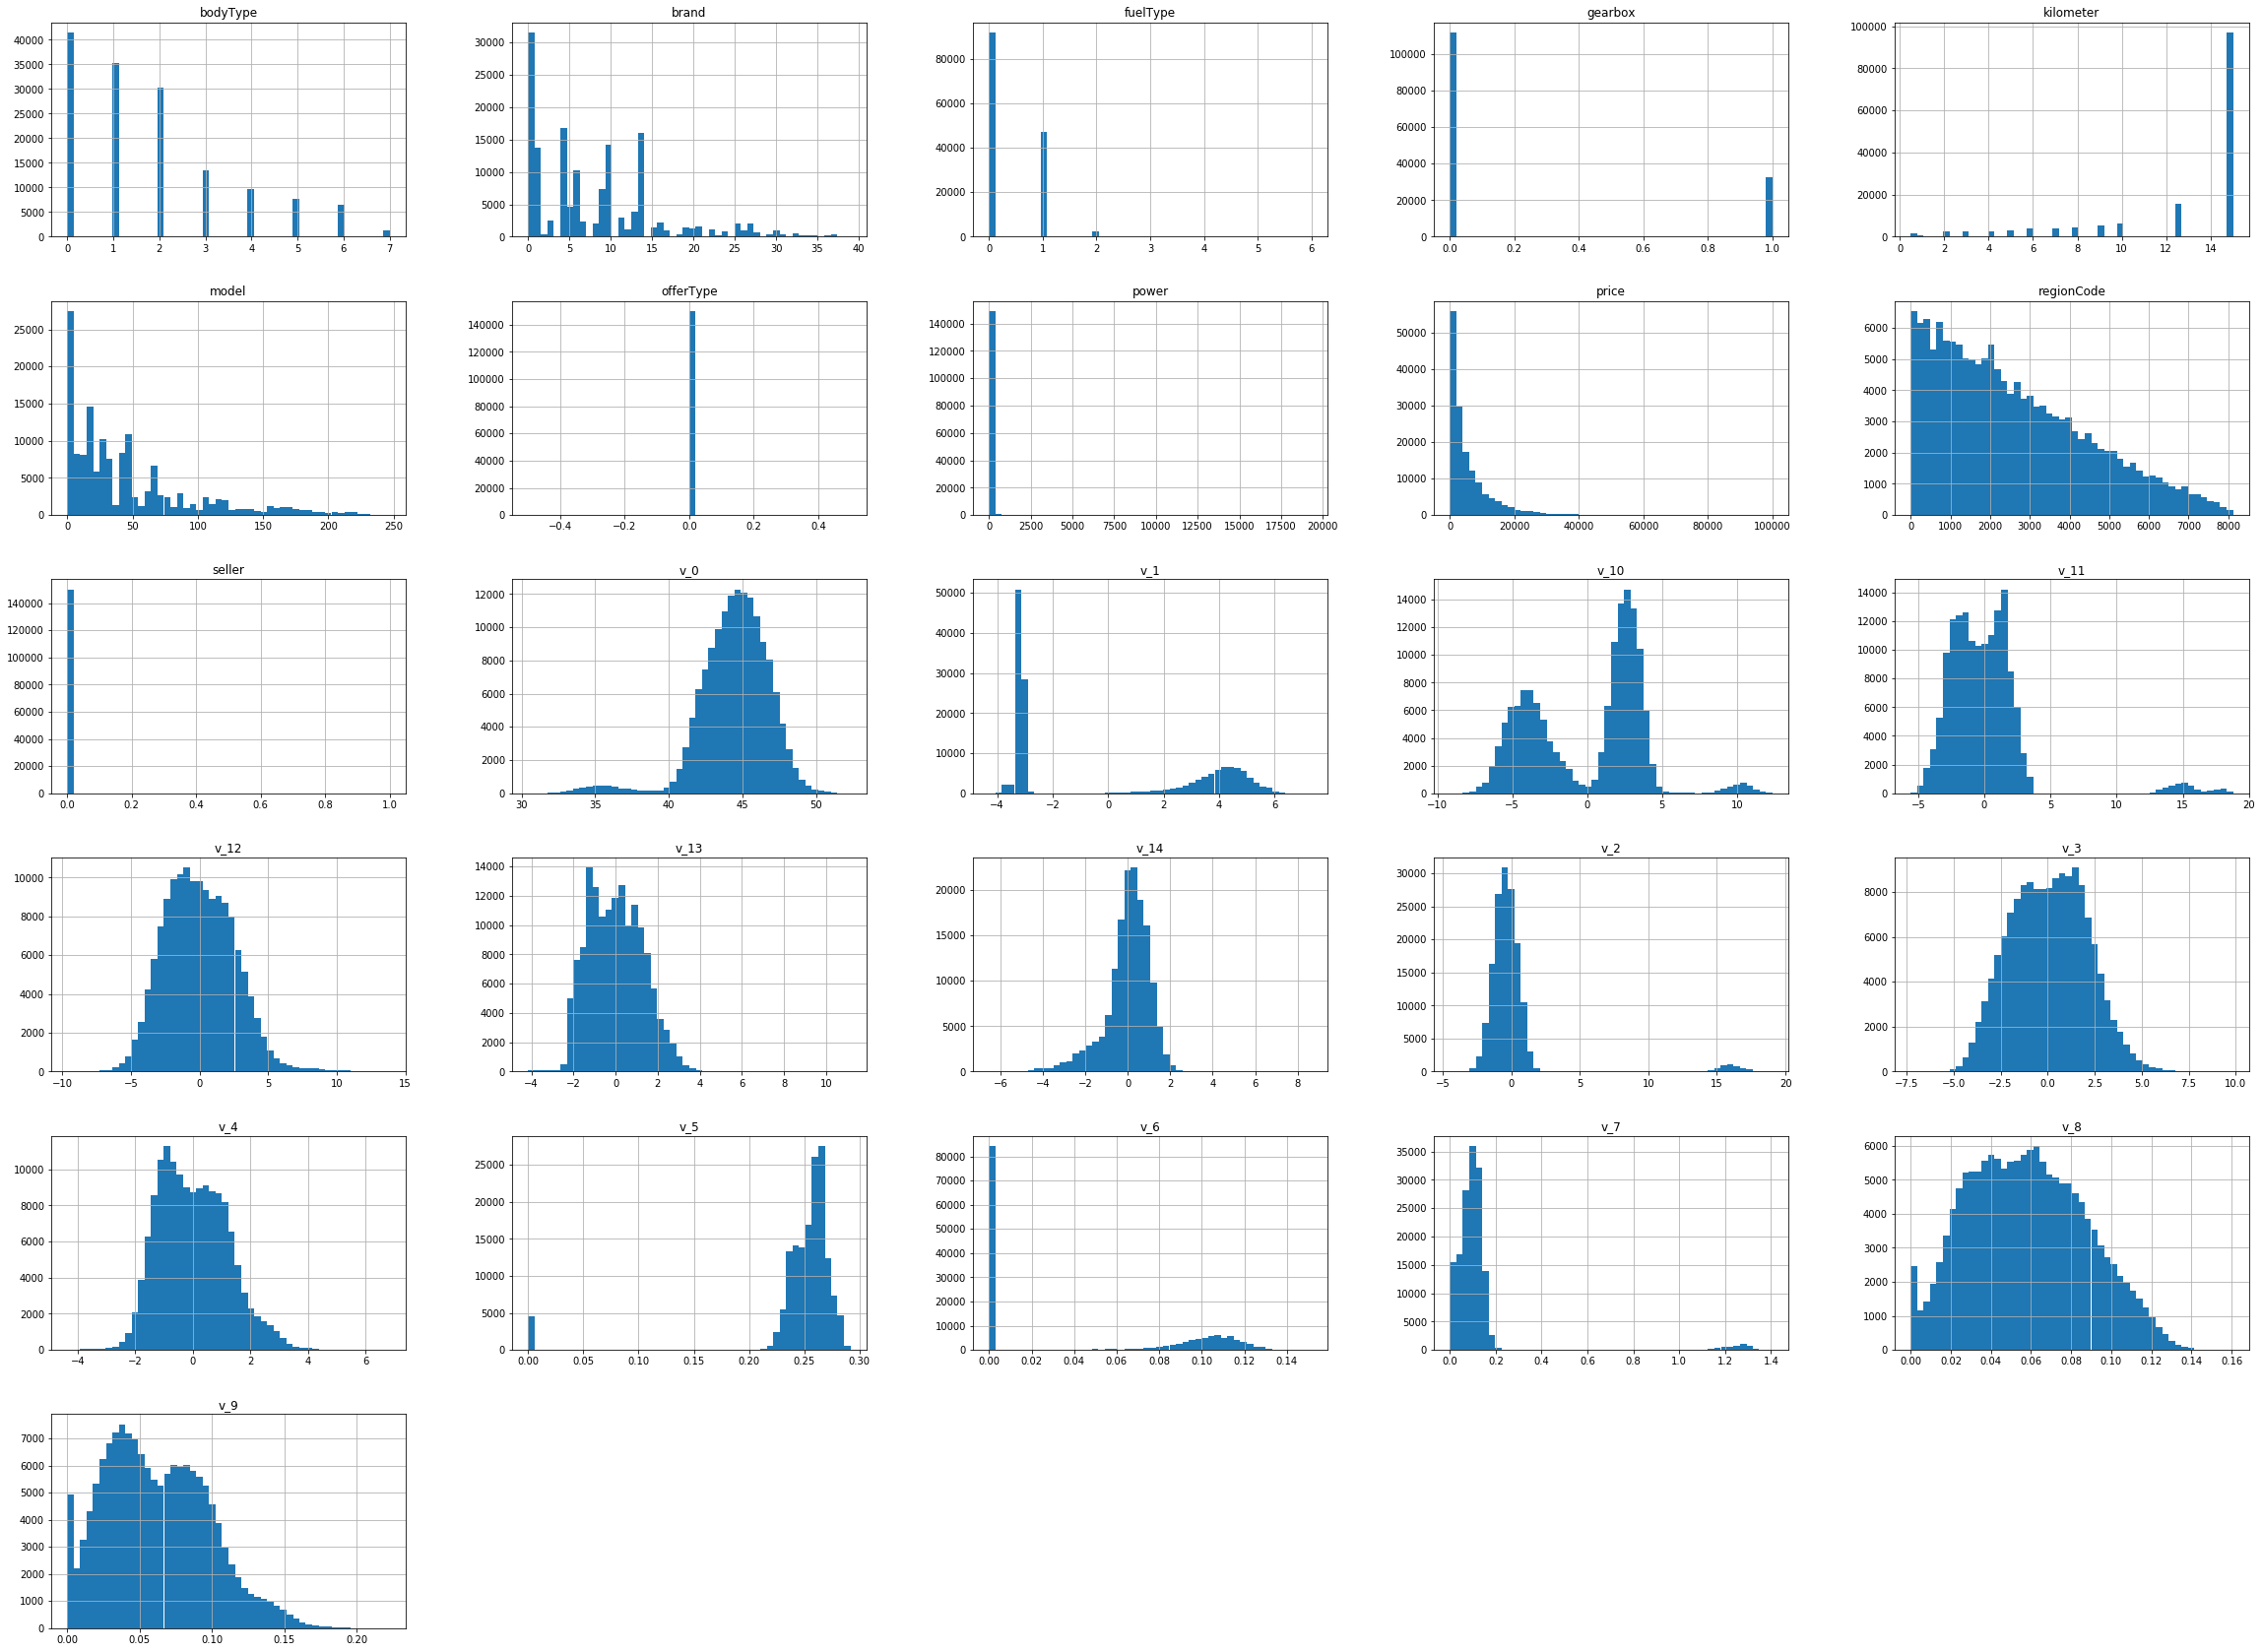

In [18]:
# 最开始放开全部cols，经过后面探索后，去掉一些特征分布。regDate，creatDate为日期类型
cols = [col for col in train_df.columns if col not in ['SaleID','name','regDate','creatDate']]
train_df[cols].hist(bins=50, figsize=(40,30))
plt.show()

### 皮尔逊相关性

In [6]:
train_df.corr(method='pearson').sort_values(by='price')['price']

v_3          -0.730946
kilometer    -0.440519
v_11         -0.275320
v_10         -0.246175
v_9          -0.206205
v_4          -0.147085
v_7          -0.053024
brand        -0.043799
v_13         -0.013993
seller       -0.002004
SaleID       -0.001043
name          0.002030
creatDate     0.002955
regionCode    0.014036
v_14          0.035911
v_1           0.060914
v_6           0.068970
v_2           0.085322
model         0.136983
v_5           0.164317
fuelType      0.200536
power         0.219834
bodyType      0.241303
gearbox       0.329075
regDate       0.611959
v_0           0.628397
v_8           0.685798
v_12          0.692823
price         1.000000
offerType          NaN
Name: price, dtype: float64

### 用pandas_profiling生成数据报告

In [ ]:
import pandas_profiling

pfr = pandas_profiling.ProfileReport(train_df)
pfr.to_file('./example.html')

## 空值可视化

### 方法1

In [13]:
train_df.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

### 方法2

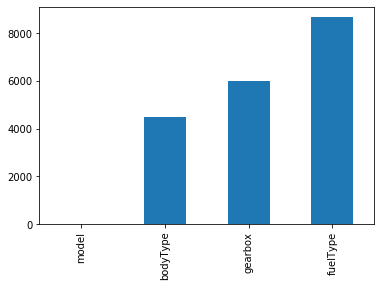

In [14]:
missing_data = train_df.isnull().sum()
missing_data = missing_data[missing_data>0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar()

### 方法3

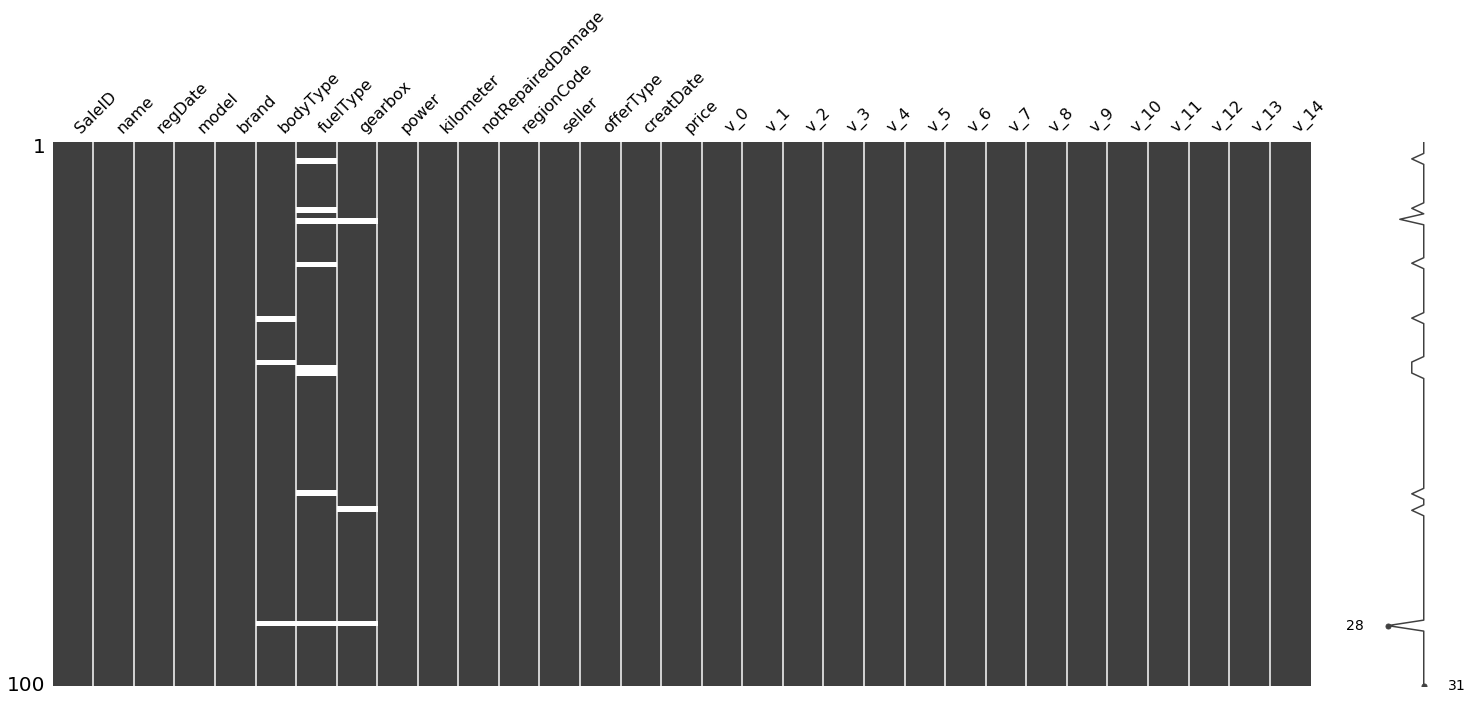

In [15]:
# 缺失值可视化
import missingno as msno

# pip install missingno
msno.matrix(train_df.sample(100, random_state=666))

### 方法4

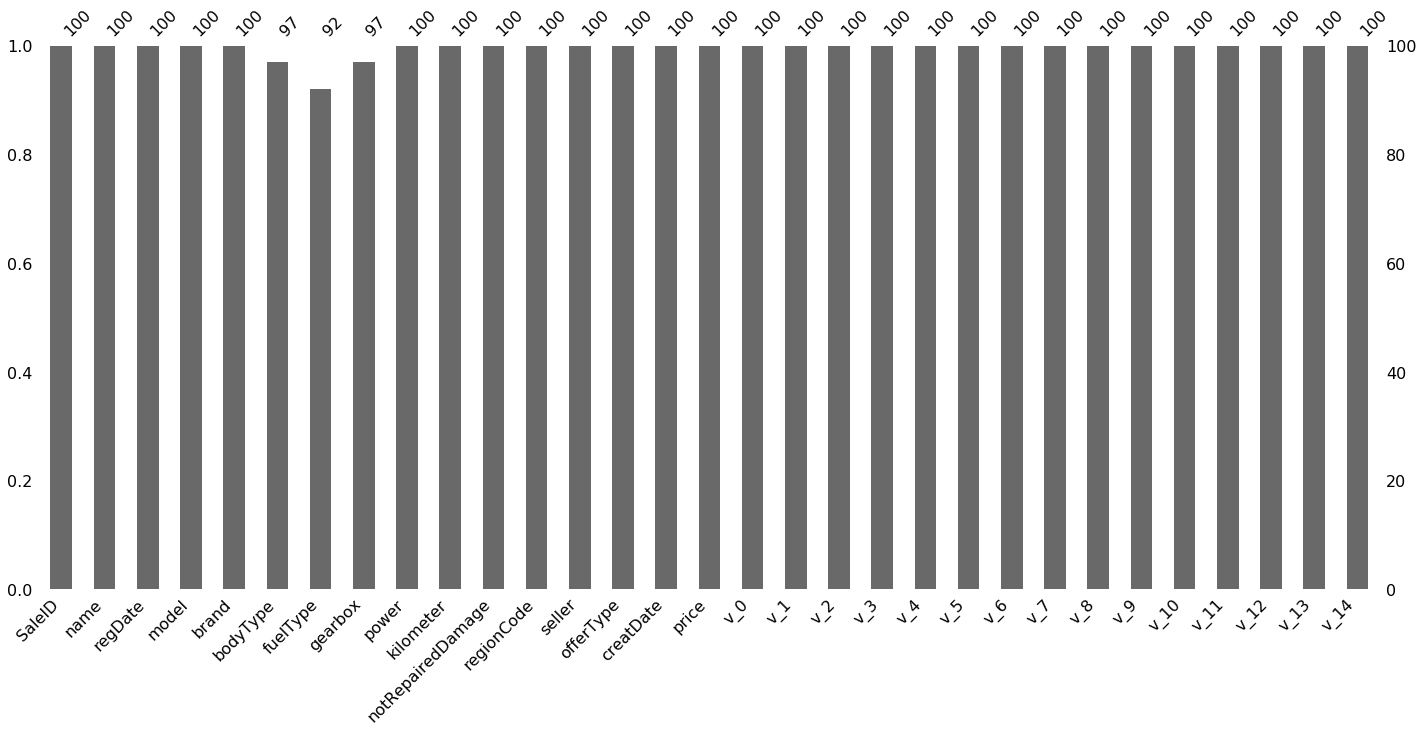

In [16]:
msno.bar(train_df.sample(100, random_state=666))

## 预测值

count    147751.000000
mean       5358.283761
std        5749.035535
min          11.000000
25%        1300.000000
50%        3200.000000
75%        7400.000000
max       30000.000000
Name: price, dtype: float64


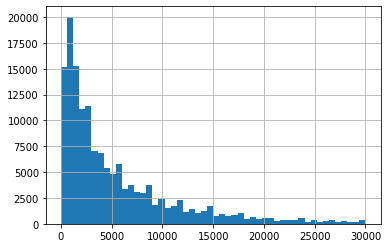

In [22]:
print(train_df[train_df['price']<=30000]['price'].describe())
train_df[train_df['price']<=30000]['price'].hist(bins=50)
plt.show()

### 总体分布

## 数字特征分析

In [24]:
numeric_features = ['regDate', 'power', 'kilometer', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


### 皮尔逊相关性

In [25]:
# 1. 皮尔逊相关性
correlation = train_df[numeric_features].corr(method='pearson')
correlation['price'].sort_values()

v_3         -0.730946
kilometer   -0.440519
v_11        -0.275320
v_10        -0.246175
v_9         -0.206205
v_4         -0.147085
v_7         -0.053024
v_13        -0.013993
creatDate    0.002955
v_14         0.035911
v_1          0.060914
v_6          0.068970
v_2          0.085322
v_5          0.164317
power        0.219834
regDate      0.611959
v_0          0.628397
v_8          0.685798
v_12         0.692823
price        1.000000
Name: price, dtype: float64

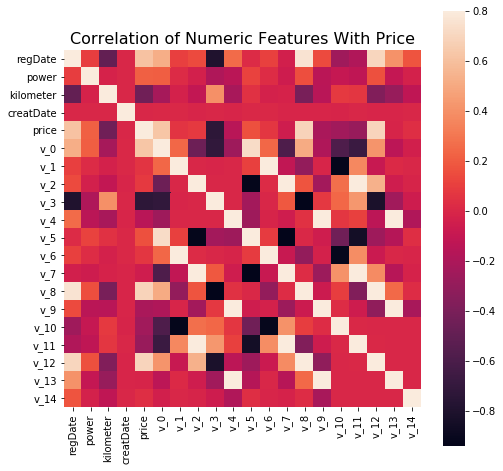

In [26]:
plt.subplots(figsize=(8, 8))
plt.title('Correlation of Numeric Features With Price', y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8)

### 偏度和峰值

In [27]:
for col in numeric_features:
    print('{:15}'.format(col),
         'Skewness: {:05.2f}'.format(train_df[col].skew()),
         '  ',
         'Kurtosis: {:06.2f}'.format(train_df[col].kurt()),          
         
         )

regDate         Skewness: 00.03    Kurtosis: -00.70
power           Skewness: 65.86    Kurtosis: 5733.45
kilometer       Skewness: -1.53    Kurtosis: 001.14
creatDate       Skewness: -79.01    Kurtosis: 6881.08
price           Skewness: 03.35    Kurtosis: 019.00
v_0             Skewness: -1.32    Kurtosis: 003.99
v_1             Skewness: 00.36    Kurtosis: -01.75
v_2             Skewness: 04.84    Kurtosis: 023.86
v_3             Skewness: 00.11    Kurtosis: -00.42
v_4             Skewness: 00.37    Kurtosis: -00.20
v_5             Skewness: -4.74    Kurtosis: 022.93
v_6             Skewness: 00.37    Kurtosis: -01.74
v_7             Skewness: 05.13    Kurtosis: 025.85
v_8             Skewness: 00.20    Kurtosis: -00.64
v_9             Skewness: 00.42    Kurtosis: -00.32
v_10            Skewness: 00.03    Kurtosis: -00.58
v_11            Skewness: 03.03    Kurtosis: 012.57
v_12            Skewness: 00.37    Kurtosis: 000.27
v_13            Skewness: 00.27    Kurtosis: -00.44
v_14     

### 分布可视化

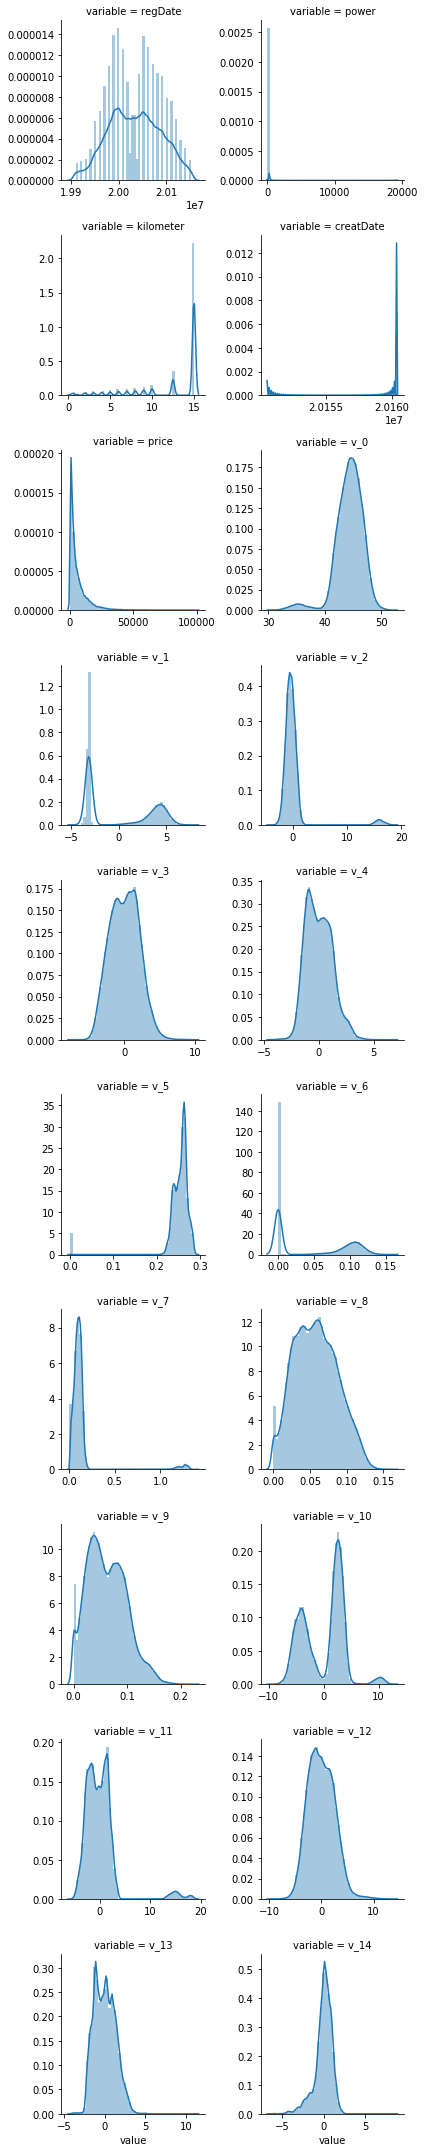

In [28]:
f = pd.melt(train_df, value_vars=numeric_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

### 数字特征相互之间的关系可视化

In [29]:
# 运行时间太久
# sns.set()
# sns.pairplot(train_df[numeric_features], size=2, kind='scatter', diag_kind='kde')
# plt.show()

## 分类特征分析

In [30]:
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']


### 类型数据量

In [31]:
for col in categorical_features:
    print('{0}: {1}'.format(col, train_df[col].nunique()))

name: 99662
model: 248
brand: 40
bodyType: 8
fuelType: 7
gearbox: 2
notRepairedDamage: 3
regionCode: 7905


### 类别特征箱型图可视化

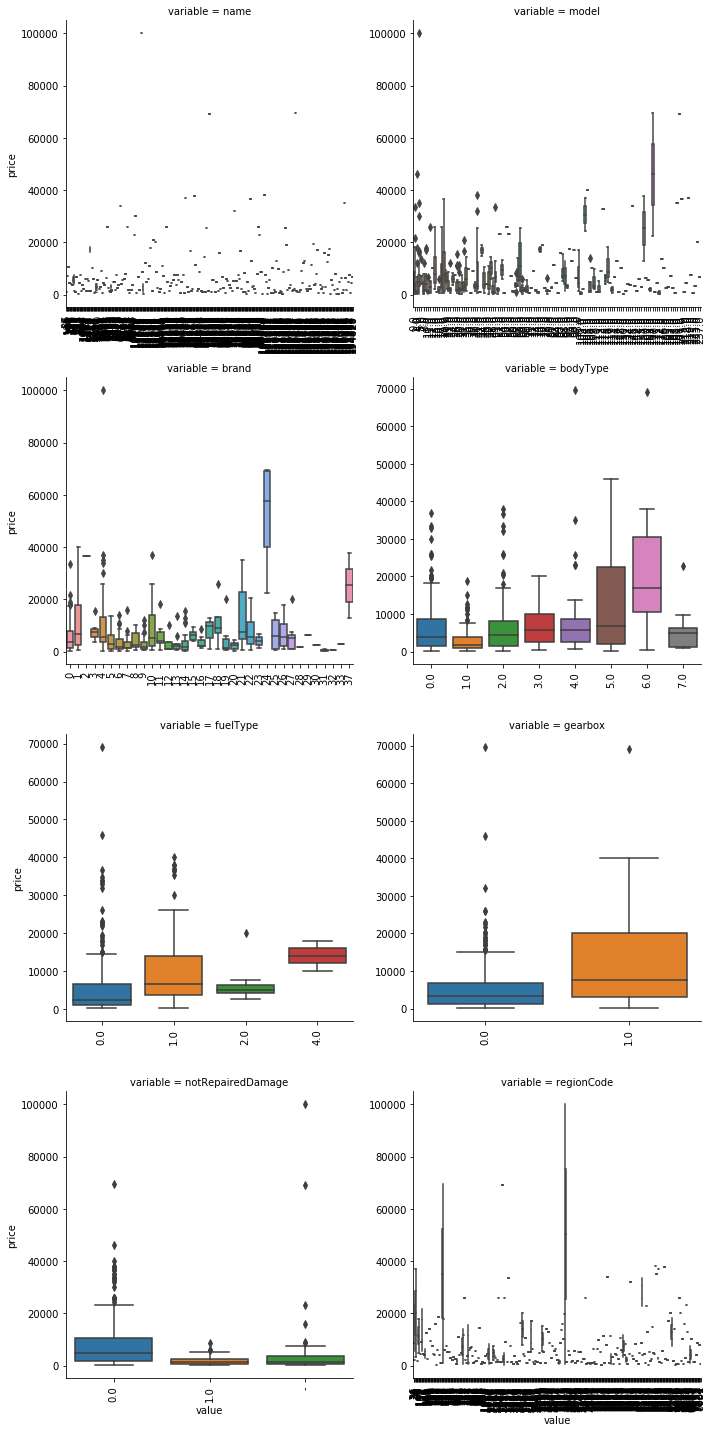

In [32]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'price')

### 类别特征的小提琴可视化

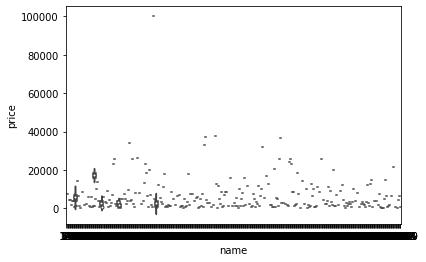

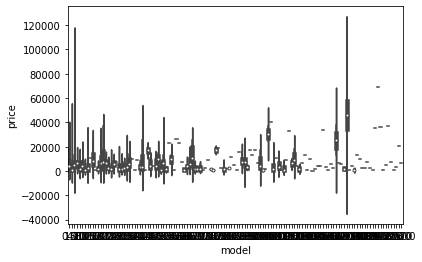

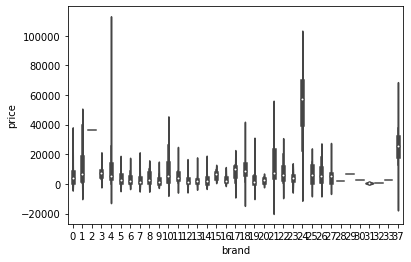

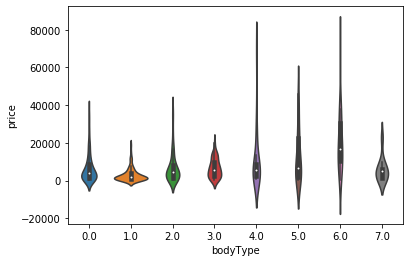

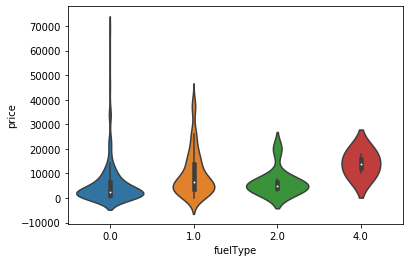

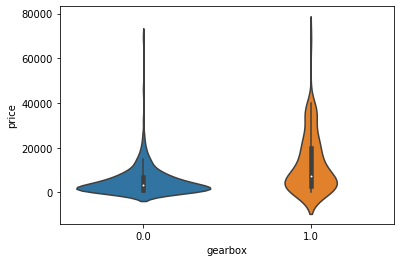

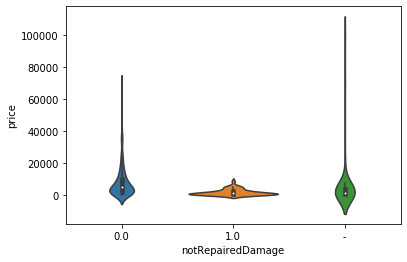

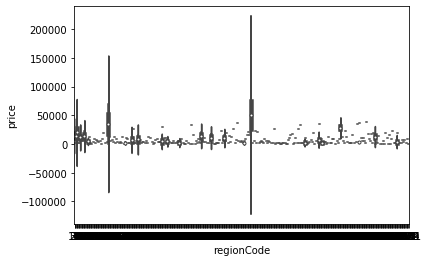

In [33]:
for col in categorical_features:
    sns.violinplot(x=col, y='price', data=train_df.sample(random_state=666, n=500))
    plt.show()

### 类别特征的柱形图可视化

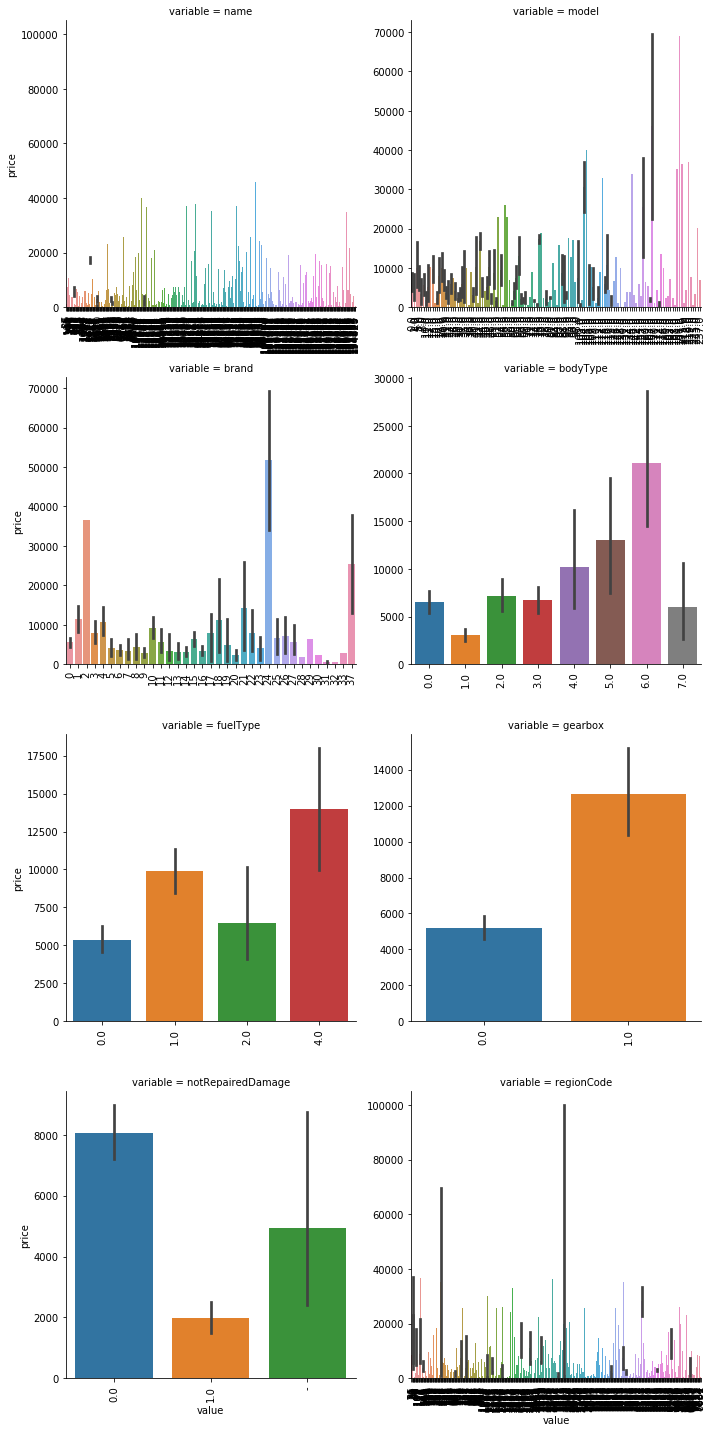

In [34]:
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(bar_plot, 'value', 'price')

### 类别特征的每个类别频数可视化

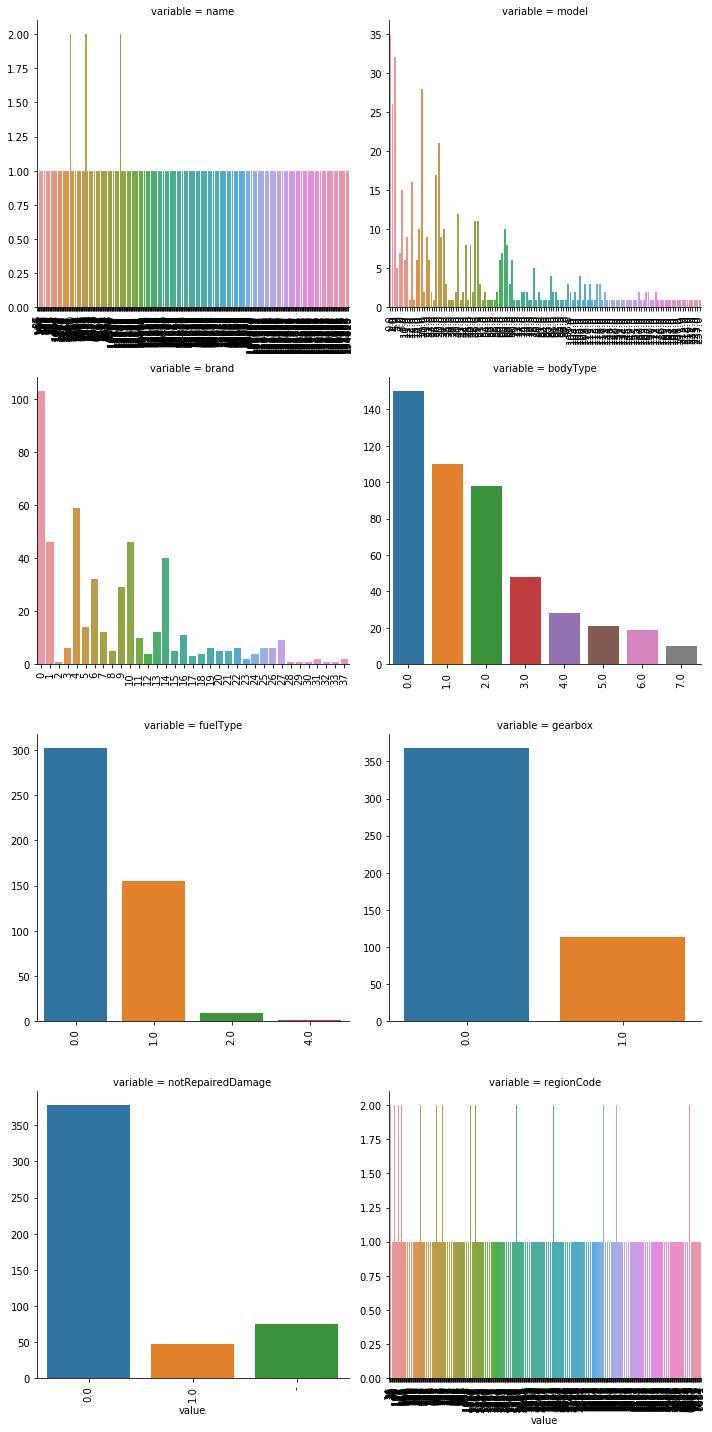

In [35]:
def count_plot(x, **kwargs):
    sns.countplot(x=x)
    x = plt.xticks(rotation=90)

f = pd.melt(train_df.sample(random_state=666, n=500), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(count_plot, 'value')